In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from hyppo.discrim import DiscrimOneSample
from sklearn.covariance import GraphicalLasso
from sklearn.linear_model import LinearRegression

Measure: corr
Run experiment in 263.2 seconds
DISCR mean = 0.503, std:0.014
p values mean = 0.466, std:0.226
Measure: cov
Run experiment in 267.1 seconds
DISCR mean = 0.502, std:0.008
p values mean = 0.491, std:0.063
Measure: inv_cov
Run experiment in 278.7 seconds
DISCR mean = 0.700, std:0.031
p values mean = 0.001, std:0.001
Measure: mean_corr
Run experiment in 264.7 seconds
DISCR mean = 0.718, std:0.050
p values mean = 0.004, std:0.007
Measure: var_corr
Run experiment in 255.1 seconds
DISCR mean = 0.891, std:0.027
p values mean = 0.001, std:0.000
Measure: A_hat
Run experiment in 271.6 seconds
DISCR mean = 0.999, std:0.002
p values mean = 0.001, std:0.000


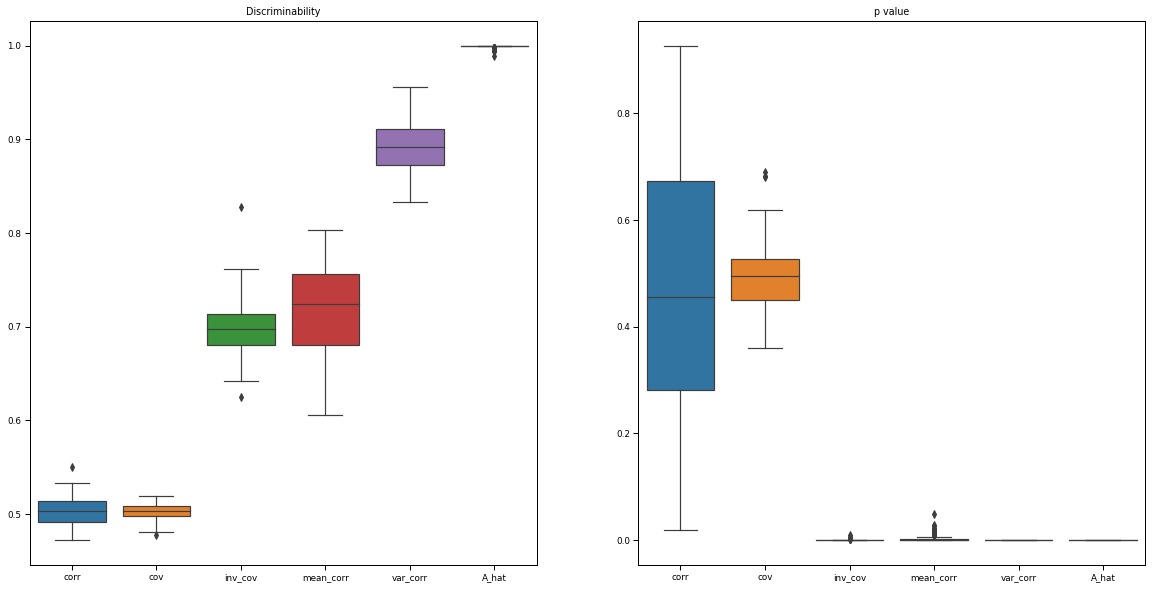

In [3]:
def sample_data(subjects=10, trials=2, nodes=10, win_length=10, total_length=100,
                step_size=10, seed=None, measure='corr'):
    if seed is not None:
        np.random.seed(seed)

    measurements = []
    times = list(np.arange(0, total_length - win_length + 1, step_size))
    time_steps = len(times)
    for j in range(subjects):
        # phi = 0.5
        phi = 0.1*j  # phi=0:0.1:0.9
        # phi = 0.2*j - 0.9  # A=-0.9:0.2:0.9
        # A = np.diag(np.ones(nodes))*phi - 0.1*np.ones([nodes, nodes]) # MAR(1) coefficient matrix
        A = np.diag(np.ones(nodes)) * phi - 0.1 * np.diag(np.ones(nodes - 1), k=-1)  # MAR(1) sparse coefficient matrix
        for s in range(trials):
            # Simulate time series for each trial
            X = np.zeros((nodes, total_length))
            X[:,0] = np.random.normal(size=nodes)
            for i in range(np.size(X, 1) - 1):
                epsilon = np.random.normal(size=nodes)
                X[:, i + 1] = A.dot(X[:, i]) + epsilon
            if measure == 'A_hat':
                reg = LinearRegression().fit(X[:, :-1].transpose(), X[:, 1:].transpose())
                A_hat = reg.coef_
                measurements.append(A_hat.flatten())

            else:
                # Calculate correlation matrix with sliding window method
                features = []

                for i, t in enumerate(times):
                    if measure in ['corr', 'mean_corr', 'var_corr']:
                        corr_matrix = np.corrcoef(X[:, t:t + step_size])
                        features.append(corr_matrix.flatten())
                    elif measure == 'cov':
                        cov_matrix = np.cov(X[:, t:t + step_size])
                        features.append(cov_matrix.flatten())
                    elif measure == 'inv_cov':
                        cov = GraphicalLasso(alpha=1).fit(X[:, t:t + step_size].T)
                        features.append(cov.covariance_.flatten())

                if measure in ['corr', 'cov', 'inv_cov']:
                    measurements.append(np.asarray(features).flatten())
                elif measure == 'mean_corr':
                    measurements.append(np.mean(np.asarray(features), axis=0))
                elif measure == 'var_corr':
                    measurements.append(np.var(np.asarray(features), axis=0))

    measurements = np.asarray(measurements)
    # subjects*trials measurements in total
    labels = np.repeat(np.arange(1, subjects + 1), trials)

    return measurements, labels


def run_exp(seed=None, win_length=10, total_length=100, step_size=10, trials=2, measure='corr'):
    x, y = sample_data(seed=seed, win_length=win_length, total_length=total_length, step_size=step_size, trials=trials, measure=measure)
    stats, p = DiscrimOneSample().test(x, y)

    return stats, p


def main():
    total_length = 1000
    win_length = 50
    step_size = 50
    trials = 2
    measures = ['corr', 'cov', 'inv_cov', 'mean_corr', 'var_corr', 'A_hat']
    par = Parallel(n_jobs=8, verbose=0)
    np.random.seed(8888)
    n_sims = 100
    seeds = np.random.randint(1e8, size=n_sims)
    discr_stats_data = pd.DataFrame()
    p_values_data = pd.DataFrame()
    for measure in measures:
        tic = time.perf_counter()
        res = par(delayed(run_exp)(seed=seed, win_length=win_length, total_length=total_length, step_size=step_size, trials=trials, measure=measure) for seed in seeds)
        toc = time.perf_counter()
        print(f'Measure: {measure}')
        print(f"Run experiment in {toc - tic:.1f} seconds")
        p_values = np.asarray(res)[:, 1]
        discr_stats = np.asarray(res)[:, 0]
        p_values_data[measure] = p_values
        discr_stats_data[measure] = discr_stats
        print(f"DISCR mean = {np.mean(discr_stats):.3f}, std:{np.std(discr_stats):.3f}")
        print(f"p values mean = {np.mean(p_values):.3f}, std:{np.std(p_values):.3f}")
    p_values_data.to_csv('p_values_data.csv', index=False)
    discr_stats_data.to_csv('discr_stats_data.csv', index=False)

    p_values_data = pd.read_csv('p_values_data.csv')
    discr_stats_data = pd.read_csv('discr_stats_data.csv')

    with sns.plotting_context('paper'):
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        sns.boxplot(data=discr_stats_data, ax=axes[0])
        axes[0].set_title('Discriminability')
        # axes[0].set_ylim([-0.1, 1])
        sns.boxplot(data=p_values_data, ax=axes[1])
        axes[1].set_title('p value')
        # axes[1].set_ylim([-0.1, 1])
        plt.savefig('Result.png')
    return


if __name__ == "__main__":
    main()